In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import ldc.io.hdf5 as h5io
from ldc.lisa.noise import get_noise_model  

from ngboost import NGBClassifier
from ngboost.distns import k_categorical, Bernoulli

In [2]:
plt.rcParams.update({
    # Font
    'font.family':       'serif',
    'font.serif':        ['Latin Modern Roman'],
    'font.size':         10,         # base font size
    'mathtext.fontset':   'cm',               # or 'stix'
    'mathtext.rm':        'serif',
    # Axes
    'axes.titlesize':    12,
    'axes.labelsize':    11,
    'axes.linewidth':    1.0,
    
    # Ticks
    'xtick.direction':   'in',
    'ytick.direction':   'in',
    'xtick.top':         True,
    'ytick.right':       True,
    'xtick.labelsize':   10,
    'ytick.labelsize':   10,
    
    # Grid (if you ever want one)
    'axes.grid':         False,
    'grid.linestyle':    '--',
    'grid.linewidth':    0.5,
    'grid.color':        '0.8',
    
    # Legend
    'legend.frameon':    False,
    'legend.fontsize':   10,
    
    # Figure
    'figure.figsize':    (8, 6),    # default figure size
    'figure.dpi':        300,       # high‑res
})

In [3]:
def extract_model_info(filename):
    """
    Extracts the model name and version from the filename.
    Example:
        'resolved_Model1_0_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5' -> 'Model 1.0'
        'resolved_Model1_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5' -> 'Model 1.1'
    """
    # Regular expression to capture 'Model' followed by a number, an underscore, and another number
    match = re.search(r'resolved_(Model)(\d+)_(\d+)_MW', filename)
    if match:
        model_prefix = match.group(1)      # 'Model'
        model_number = match.group(2)      # e.g., '1'
        model_version = match.group(3)     # e.g., '0', '1'
        # Format as 'Model 1.0', 'Model 1.1', etc.
        formatted_model = f"{model_prefix} {model_number}.{model_version}"
        return formatted_model
    else:
        return 'Unknown'
def process_h5_file(filepath):
    """
    Processes a single .h5 file and extracts the necessary parameters.
    Returns a pandas DataFrame with the extracted data and model information.
    """
    # Extract the model from the filename
    filename = os.path.basename(filepath)
    model = extract_model_info(filename)
    
    cats, units = h5io.load_array(filepath, 'cat')
    
    data = {
        'Name': cats['Name'],
        'Frequency': cats['Frequency'],
        'Amplitude': cats['Amplitude'],
        'FrequencyDerivative': cats['FrequencyDerivative'],
        'SNR': np.sqrt(cats['snr2']),
        'Eccentricity': cats['Eccentricity'],
        'Inclination': cats['Inclination'],
        'Polarization': cats['Polarization'],
        'EclipticLatitude': cats['EclipticLatitude'],
        'EclipticLongitude': cats['EclipticLongitude'],
        'InitialPhase': cats['InitialPhase'],
        'Model': model 
    }
    
    df = pd.DataFrame(data)
    
    return df
def compile_data_from_folder(folder_path):
    """
    Compiles data from all .h5 files in the specified folder into a single DataFrame.
    """
    all_data = []
    
    # List all .h5 files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.h5') and filename.startswith('resolved_'):
            filepath = os.path.join(folder_path, filename)
            try:
                df = process_h5_file(filepath)
                all_data.append(df)
                print(f"Processed file: {filename}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
    
    if all_data:
        # Concatenate all DataFrames
        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df
    else:
        print("No .h5 files found or no data extracted.")
        return pd.DataFrame()  # Return empty DataFrame if no data

In [4]:
resolved_folder_path = '/Users/irwin/Documents/GitHub/lisa-ml/data/resolved_binaries/'
resolved_df = compile_data_from_folder(resolved_folder_path)
resolved_df['Class'] = resolved_df['Name'].str.extract(r'MW_(DWD|NSWD)')
selected_features = ['Frequency', 'Amplitude', 'FrequencyDerivative', 'SNR', 'Eccentricity']

resolved_df = resolved_df.dropna(subset=selected_features + ['Class'])

# Encode labels: DWD=0, NSWD=1
label_encoder = LabelEncoder()
resolved_df['Class'] = label_encoder.fit_transform(resolved_df['Class'])
resolved_df['Frequency_mHz'] = resolved_df['Frequency'] * 1000
resolved_df['FrequencyDerivative_log10'] = np.log10(resolved_df['FrequencyDerivative'])
resolved_df['EclipticLatitude_sin'] = np.sin(resolved_df['EclipticLatitude'])
resolved_df['Amplitude_log10'] = np.log10(resolved_df['Amplitude'])
resolved_df['Inclination_cos'] = np.cos(resolved_df['Inclination'])

cols_to_remove = ['Frequency', 'FrequencyDerivative', 'EclipticLatitude', 'Amplitude', 'Inclination']
resolved_df.drop(columns=cols_to_remove, inplace=True)

Processed file: resolved_Model2_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5
Processed file: resolved_Model2_2_MW_DWDs_aa2CE_NSWDs_aa2CE_akick.h5
Processed file: resolved_Model3_1_MW_DWDs_agCE_NSWDs_agCE_vkick.h5
Processed file: resolved_Model3_0_MW_DWDs_agCE.h5
Processed file: resolved_Model1_1_MW_DWDs_aaCE_NSWDs_aaCE_vkick.h5
Processed file: resolved_Model1_0_MW_DWDs_aaCE.h5
Processed file: resolved_Model1_2_MW_DWDs_aaCE_NSWDs_aaCE_akick.h5
Processed file: resolved_Model2_4_MW_DWDs_aa2CE_NSWDs_aa2CE_bkick.h5
Processed file: resolved_Model1_4_MW_DWDs_aaCE_NSWDs_aaCE_bkick.h5
Processed file: resolved_Model2_3_MW_DWDs_aa2CE_NSWDs_aa2CE_hkick.h5
Processed file: resolved_Model1_3_MW_DWDs_aaCE_NSWDs_aaCE_hkick.h5


In [5]:
selected_features = [
    'Frequency_mHz', 
    'Amplitude_log10', 
    'FrequencyDerivative_log10', 
    'SNR', 
    'Eccentricity',
    'EclipticLatitude_sin',
    'Inclination_cos',
    'Polarization',
    'EclipticLongitude',
    'InitialPhase'
]

X = resolved_df[selected_features]
y = resolved_df['Class'] 

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

In [6]:
ngb_cat = NGBClassifier()

In [7]:
_ = ngb_cat.fit(
    X_train_scaled, y_train,
    X_val=X_test_scaled, Y_val=y_val
)

[iter 0] loss=0.0622 val_loss=0.0597 scale=0.5000 norm=1.0000
[iter 100] loss=0.0184 val_loss=0.0186 scale=0.5000 norm=0.5834
[iter 200] loss=0.0165 val_loss=0.0171 scale=1.0000 norm=1.1612
[iter 300] loss=0.0162 val_loss=0.0170 scale=0.0001 norm=0.0001
[iter 400] loss=0.0162 val_loss=0.0170 scale=0.0001 norm=0.0001


In [8]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, brier_score_loss,
    classification_report, confusion_matrix
)
y_val_pred = ngb_cat.predict(X_test_scaled)
y_val_prob = ngb_cat.predict_proba(X_test_scaled)[:, 1]

# Compute metrics
val_acc   = accuracy_score(y_val, y_val_pred)
val_auc   = roc_auc_score(y_val, y_val_prob)
val_brier = brier_score_loss(y_val, y_val_prob)
val_report = classification_report(y_val, y_val_pred)
val_cm     = confusion_matrix(y_val, y_val_pred)

print(f"Validation Accuracy : {val_acc:.3f}")
print(f"Validation ROC AUC   : {val_auc:.3f}")
print(f"Validation Brier     : {val_brier:.3f}\n")
print("Validation Classification Report:\n", val_report)
print("Validation Confusion Matrix:\n", val_cm)

Validation Accuracy : 0.996
Validation ROC AUC   : 0.984
Validation Brier     : 0.004

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26682
           1       1.00      0.69      0.82       314

    accuracy                           1.00     26996
   macro avg       1.00      0.85      0.91     26996
weighted avg       1.00      1.00      1.00     26996

Validation Confusion Matrix:
 [[26682     0]
 [   97   217]]


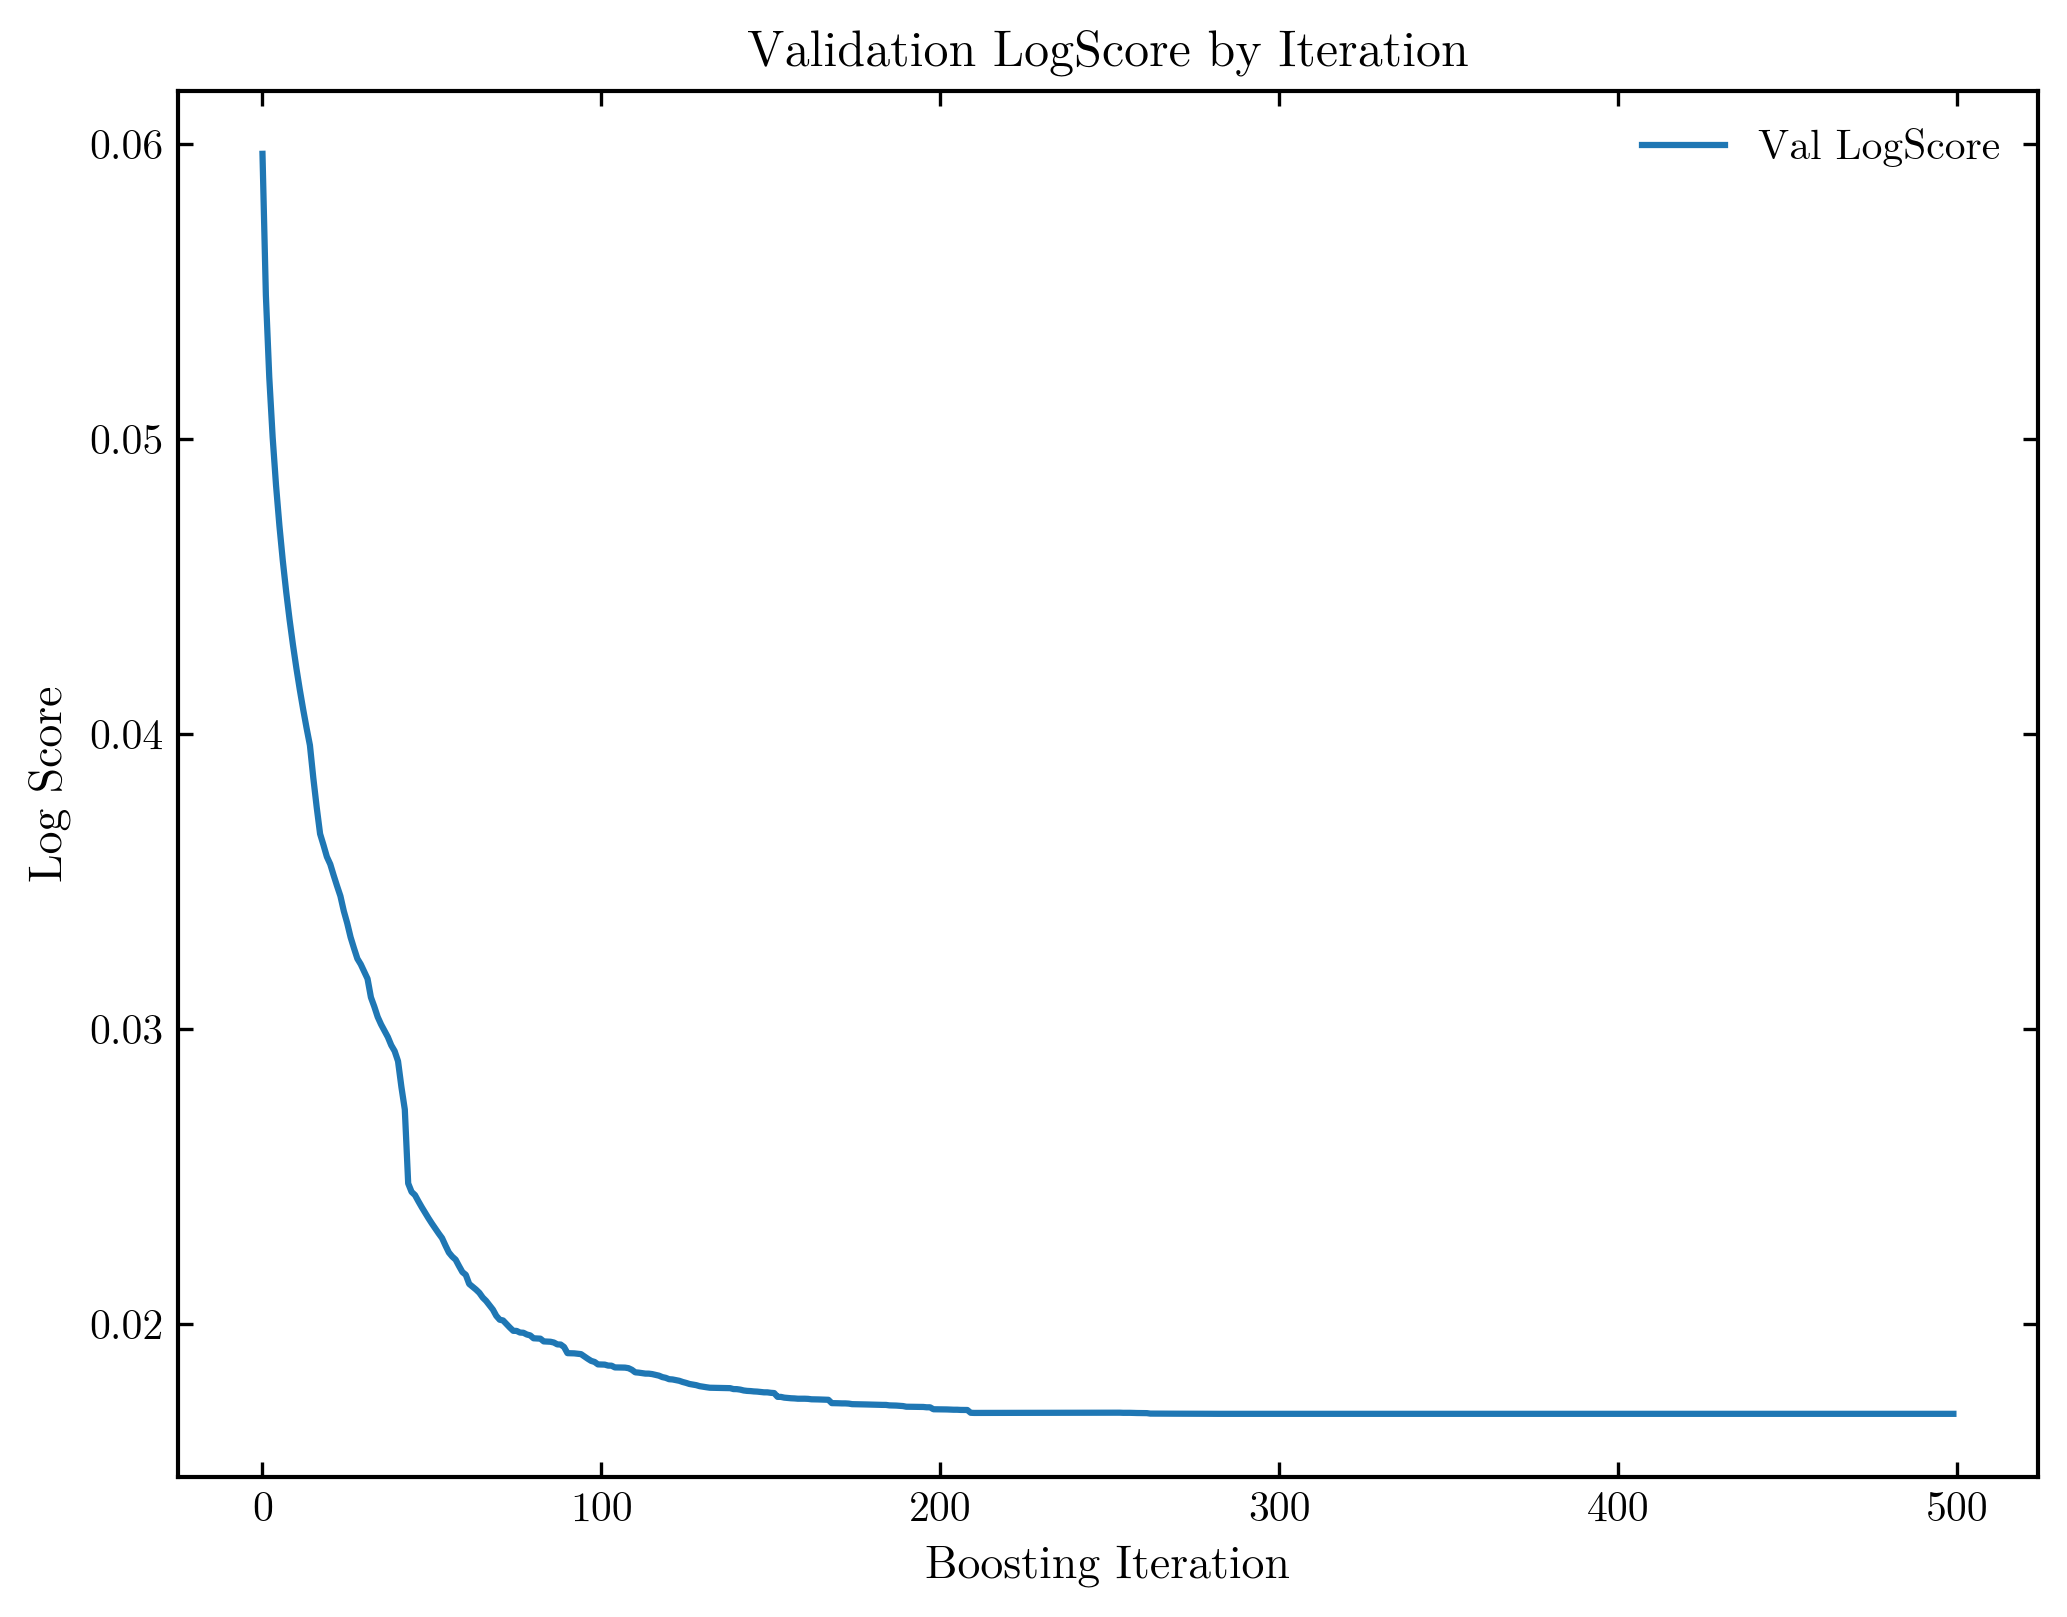

In [9]:
res = ngb_cat.evals_result
plt.plot(res['val']['LOGSCORE'], label='Val LogScore')
plt.xlabel('Boosting Iteration')
plt.ylabel('Log Score')
plt.title('Validation LogScore by Iteration')
plt.legend()
plt.show()

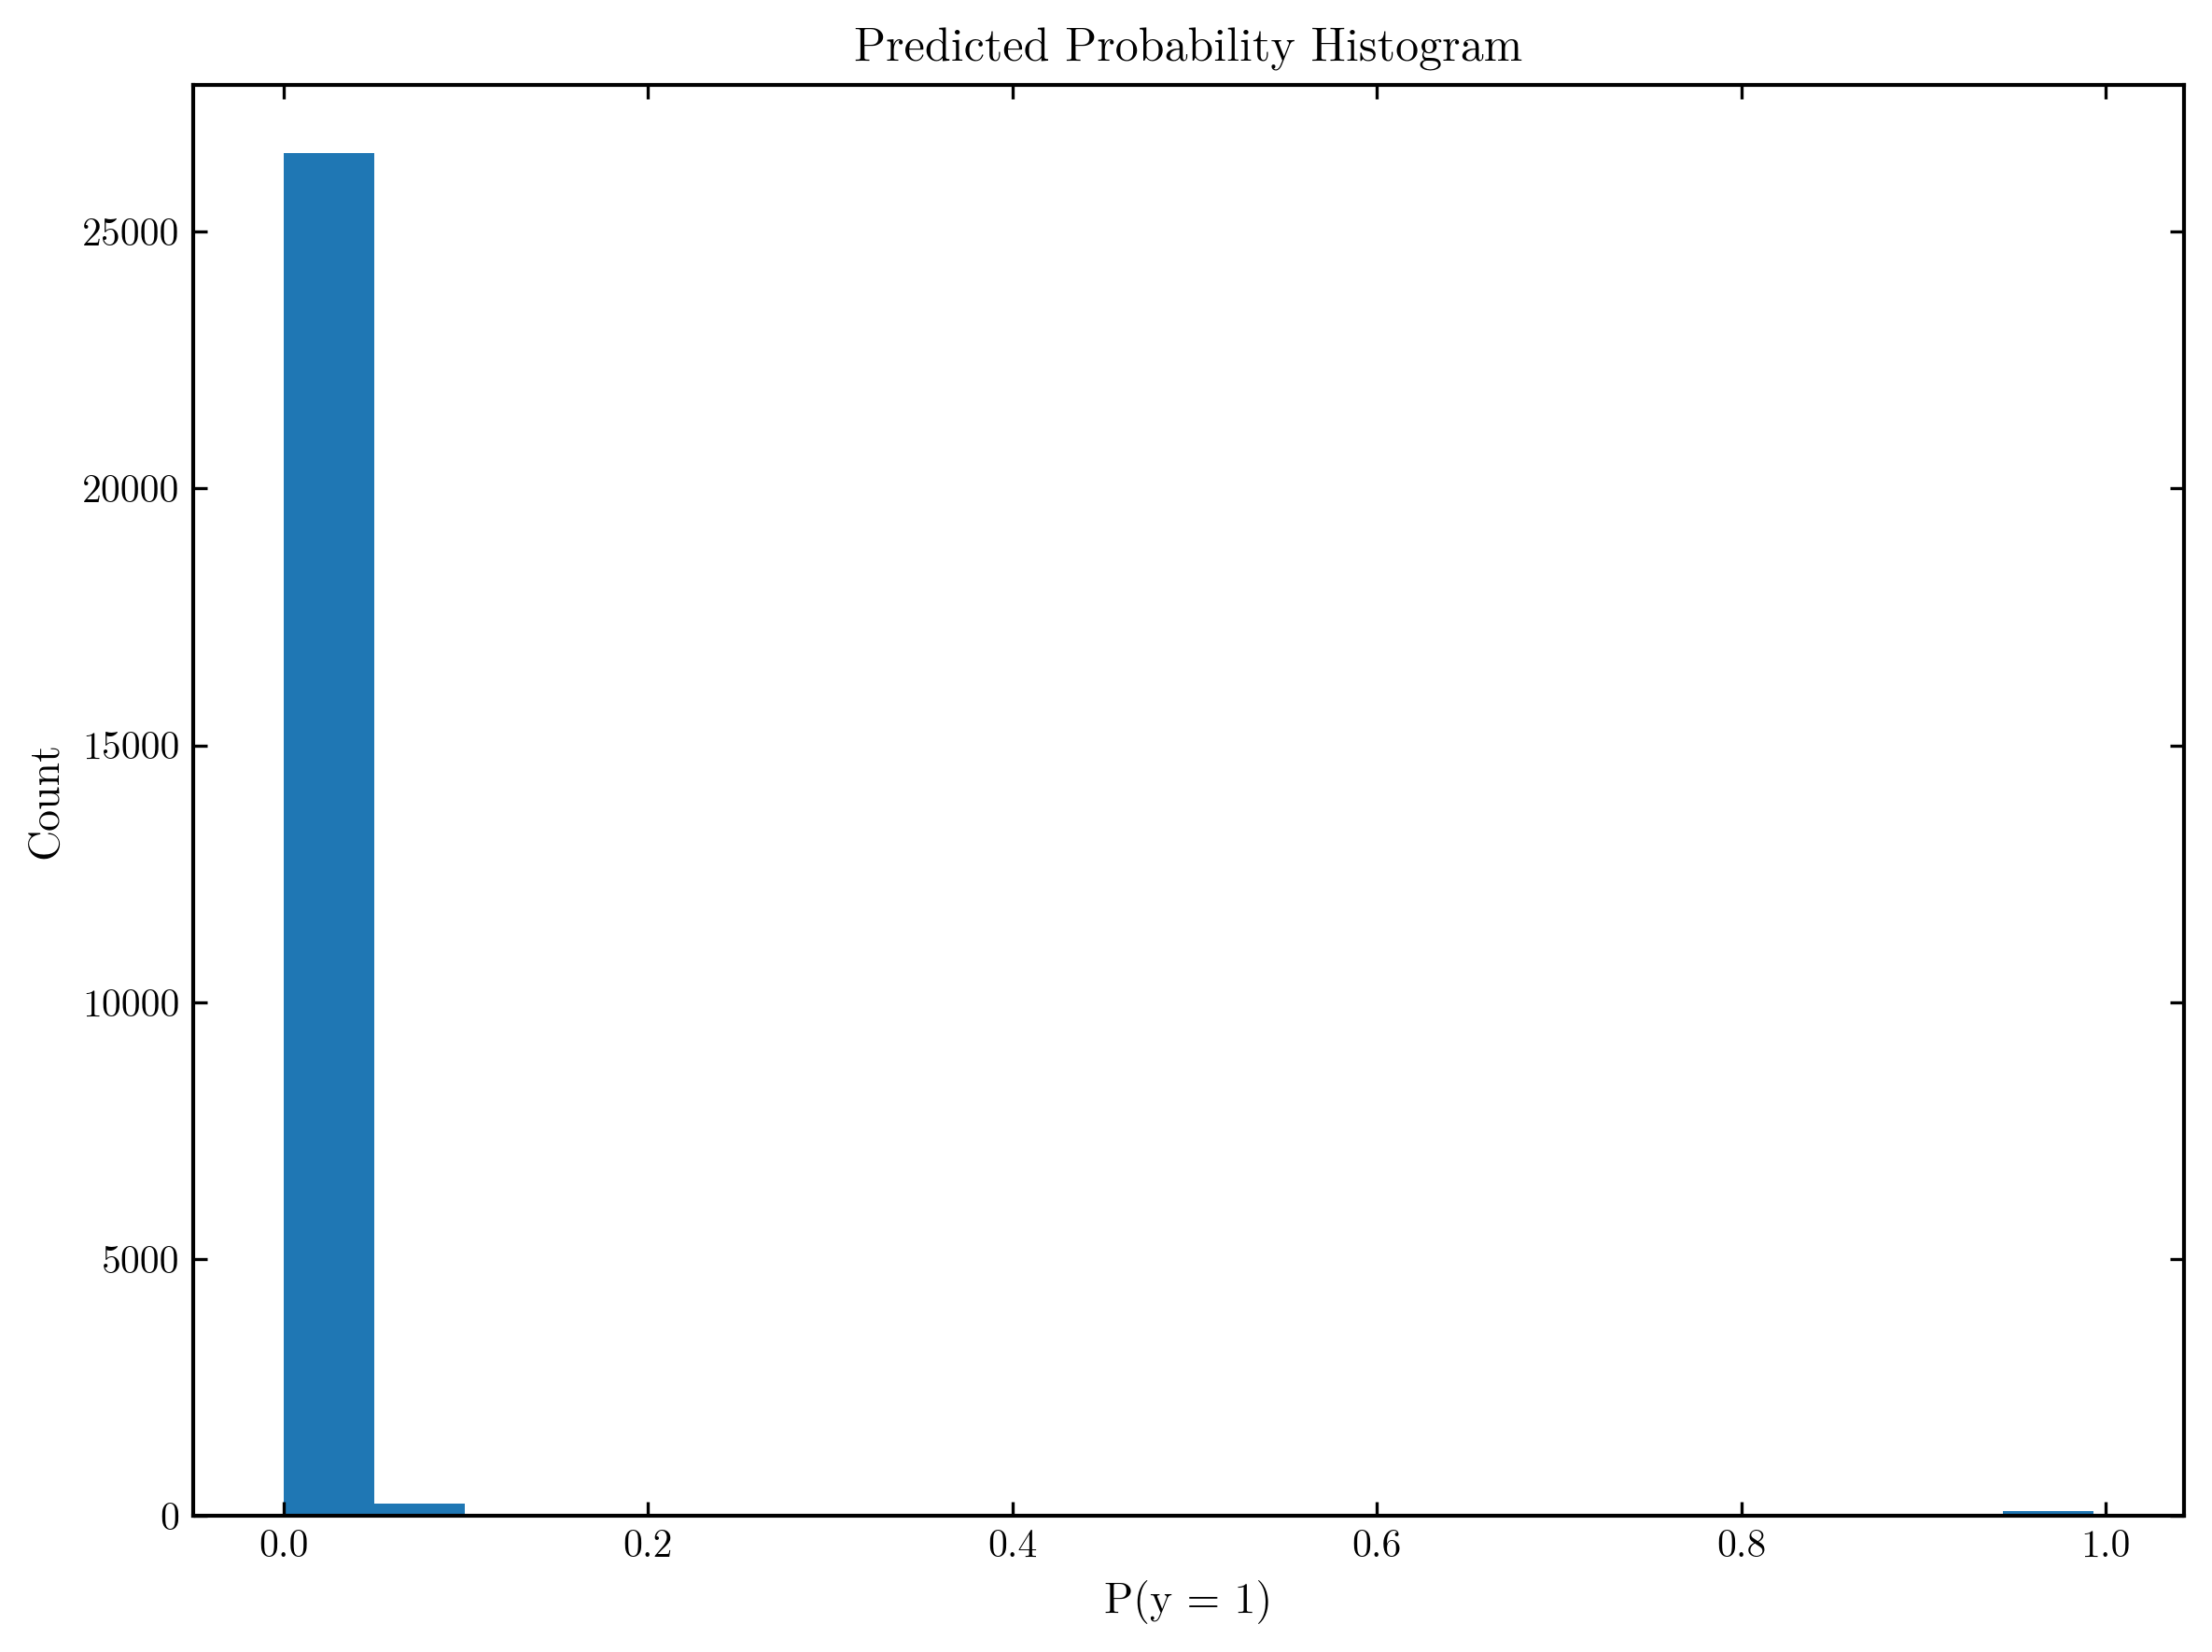

In [10]:
# 1. Extract the class‑1 probabilities
proba = ngb_cat.predict_proba(X_test_scaled)[:, 1]

# 2. Globally set the font family and size
plt.rc('font', family='Latin Modern Roman', size=10)

# 3. Create the histogram
plt.figure()
plt.hist(proba, bins=20)           # default styling, one plot only
plt.title('Predicted Probability Histogram')
plt.xlabel('P(y = 1)')
plt.ylabel('Count')

# 4. Show it
plt.tight_layout()
plt.show()

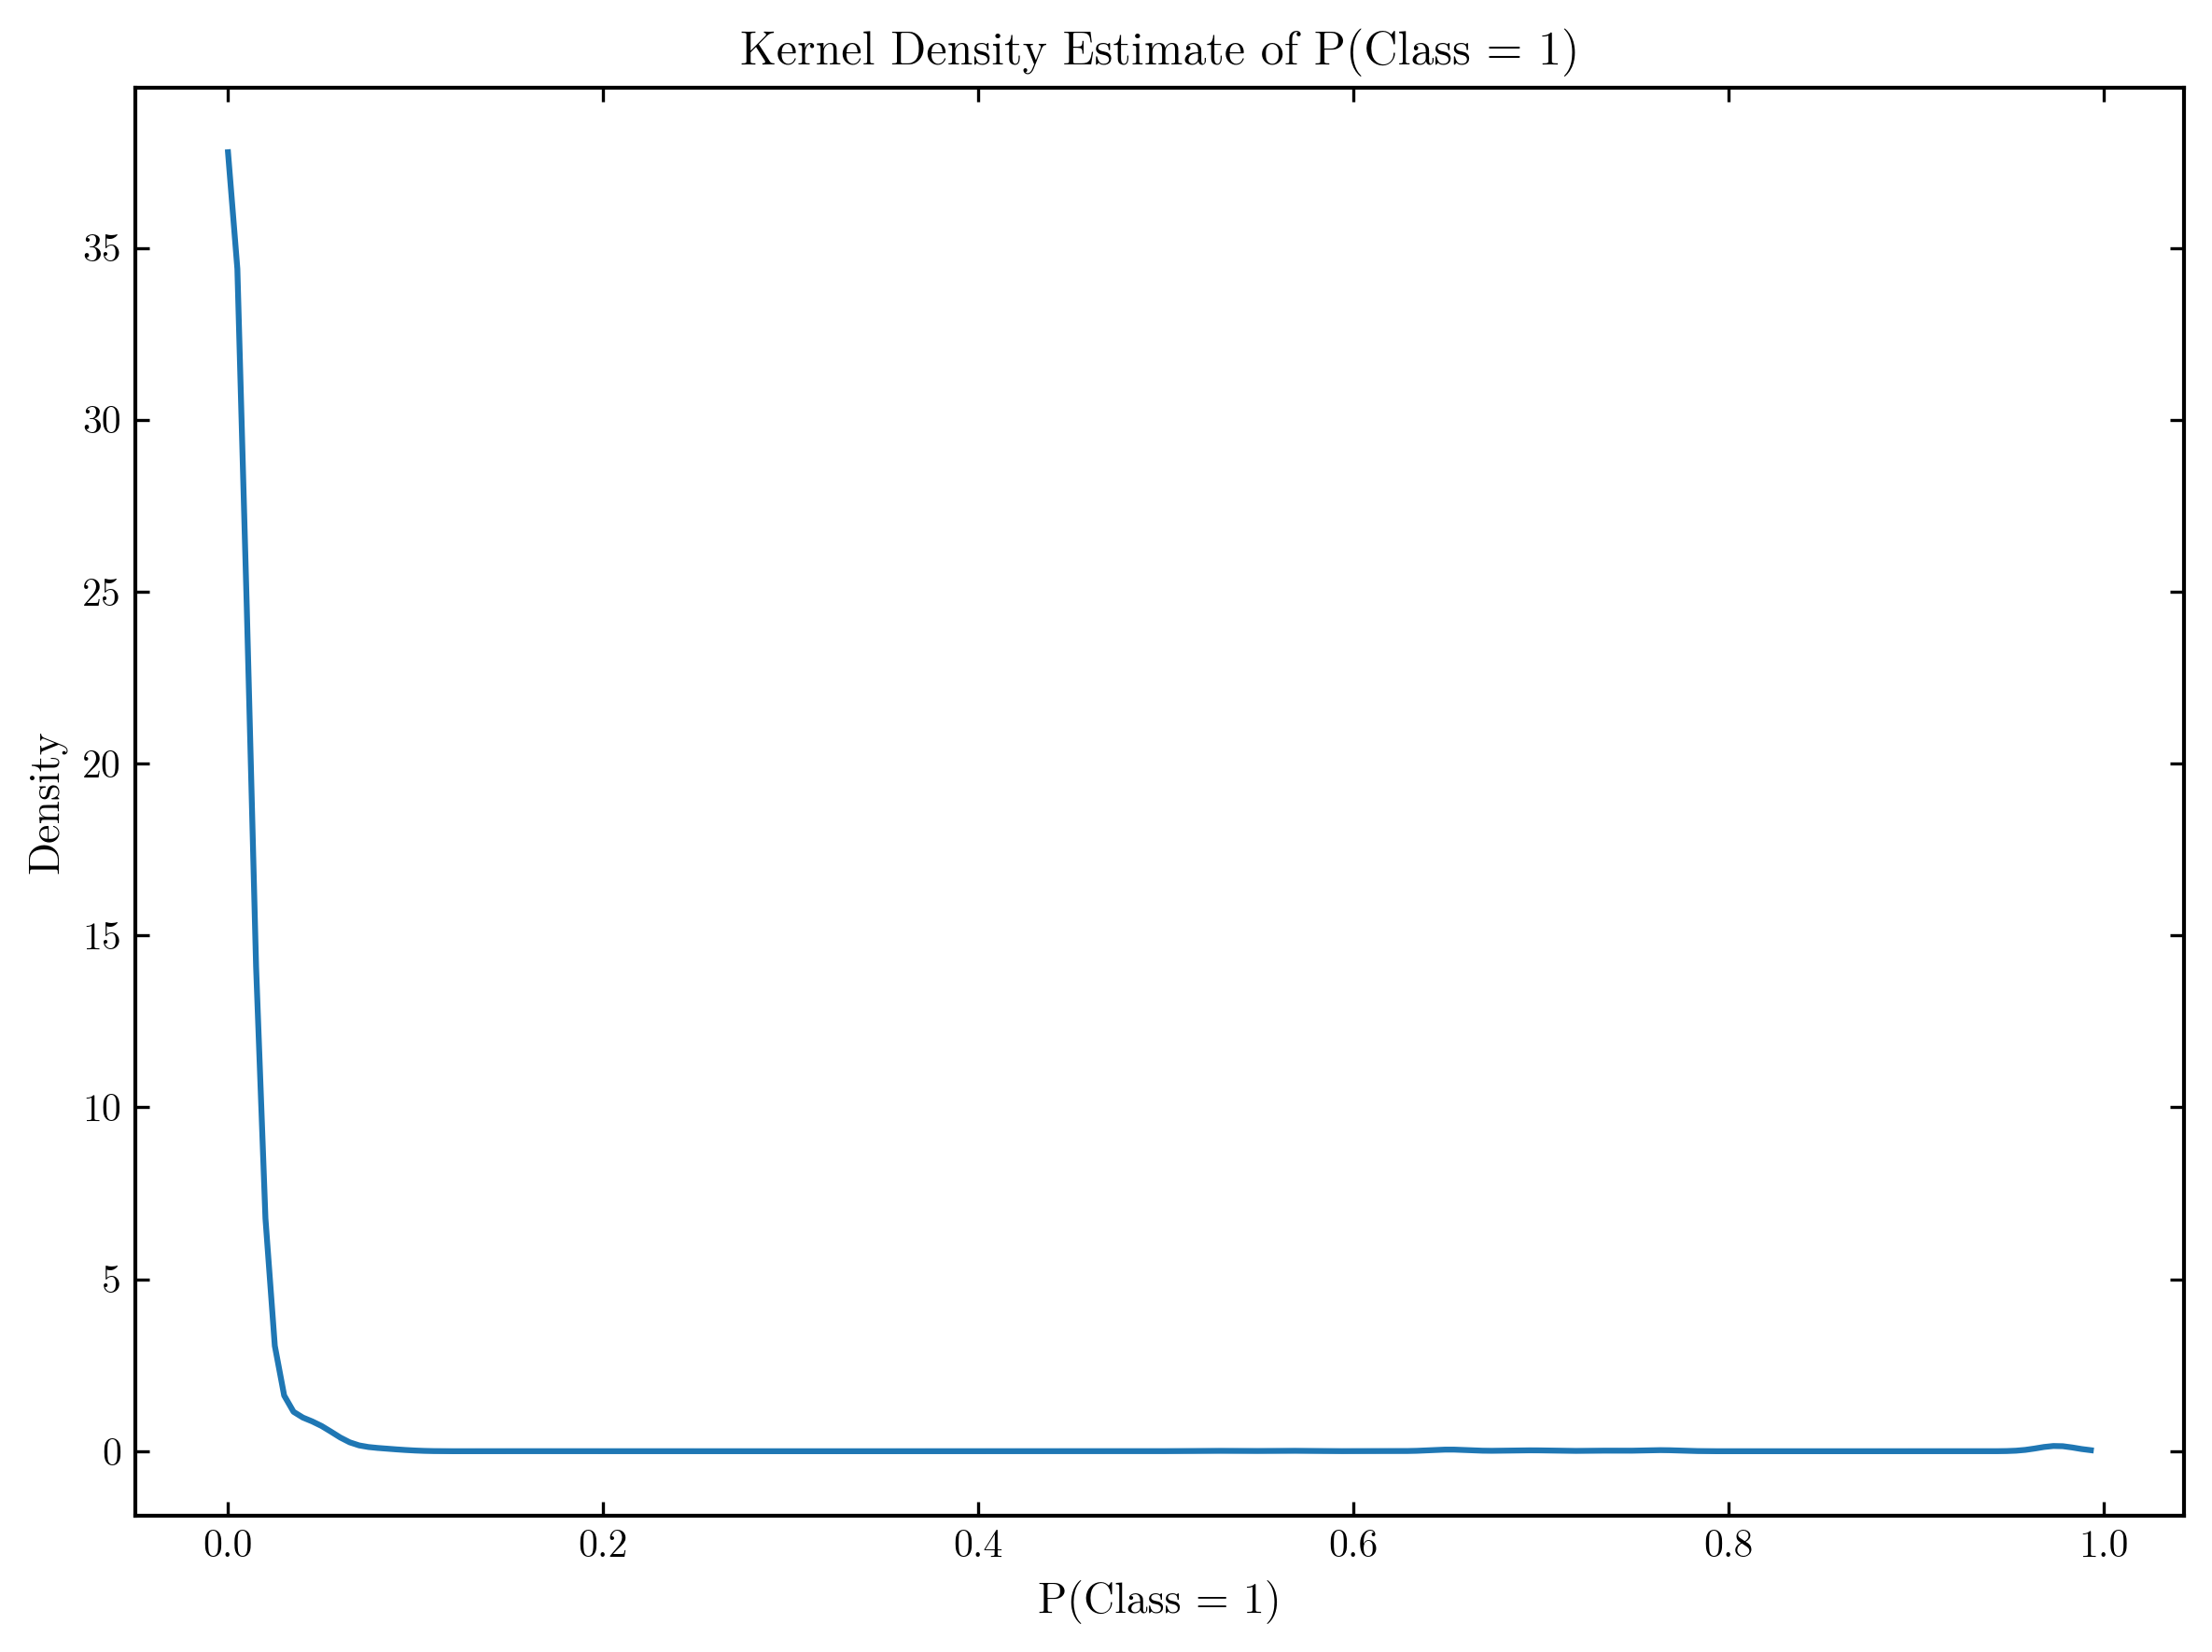

In [11]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# 1. Extract P(Class=1) for each test sample
dists = ngb_cat.pred_dist(X_test_scaled)
p1 = dists.probs[1, :]

# 2. Globally set font to Latin Modern Roman at 10 pt
plt.rc('font', family='Latin Modern Roman', size=10)

# 3. Fit a Gaussian KDE to the probabilities
kde = gaussian_kde(p1)

# 4. Prepare a smooth x‑axis over the observed range
xs = np.linspace(p1.min(), p1.max(), 200)

# 5. Plot the density curve
plt.figure()
plt.plot(xs, kde(xs))
plt.title('Kernel Density Estimate of P(Class = 1)')
plt.xlabel('P(Class = 1)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [14]:
from ldc.common.constants import SPEED_OF_LIGHT, GM_SUN, PARSEC, ASTRONOMICAL_YEAR

# Estimate luminosity distance (in kpc) from GW amplitude, frequency, and frequency derivative
def get_DL(Amp0, f0, fdot):
    return (5/(96*(np.pi**2)))*(SPEED_OF_LIGHT/Amp0)*(fdot)/np.power(f0,3)*(1/(1000*PARSEC))

# Estimate chirp Mass
def get_Mc(f0, fdot):
    return SPEED_OF_LIGHT**3/GM_SUN * ( (5/96) * np.pi**(-8/3) * f0**(-11/3) * fdot)**(3/5)
freq_mHz = X_val['Frequency_mHz']                 # in mHz
f       = freq_mHz / 1000                         # convert to Hz
amp_log  = X_val['Amplitude_log10']               # log10(h0)
h0      = 10**amp_log                             # strain amplitude
fdot_log = X_val['FrequencyDerivative_log10']     # log10(df/dt)
fdot    = 10**fdot_log  
dL    = get_DL(h0, f, fdot) # Transform to the distances and chirp masses
Mchrp = get_Mc(f, fdot)
hc = np.sqrt(16/5) * np.sqrt(Tobs*f) * h0
X_val['h_c'] = hc

In [15]:
Tobs     = 4*ASTRONOMICAL_YEAR                # Duration of the measurement
f_range        = np.linspace(1e-4,1e-1,1000)        # The frequency array
lisa_noise = get_noise_model('SciRDv1', f_range)

In [16]:
# Define the sky-averaged response function
def response_AE(f):
    """
    The sky averaged LISA response function for the A and E TDI channels.
    """
    lisaLT = lisa_noise.arm_length/SPEED_OF_LIGHT
    x = 2.0 * np.pi * lisaLT * f 
    return np.absolute(9/20 /(1 + (3 *x/4)**2 ) * ((16 * x**2 * np.sin(x)**2))) / 2
def compute_hGB(Mchrp, f0, dL):
    """
    Compute the point signals of the recovered binaries. 
    Taken from arXiv:1803.01944 (see eq. (27) )
    
    Mchirp - The chirp mass
    f0     - Source frequency
    dL     - The distance
    
    """
    nom   = 8*np.sqrt(Tobs)*(GM_SUN*Mchrp/SPEED_OF_LIGHT**3)**(5/3) * np.pi**(2/3) * f0**(2/3) 
    denom = np.sqrt(5) * dL * (1000*PARSEC) / SPEED_OF_LIGHT
    return nom/denom

In [17]:
resolved_sources = compute_hGB(Mchrp, f, dL)
lisasens = lisa_noise.sensitivity()

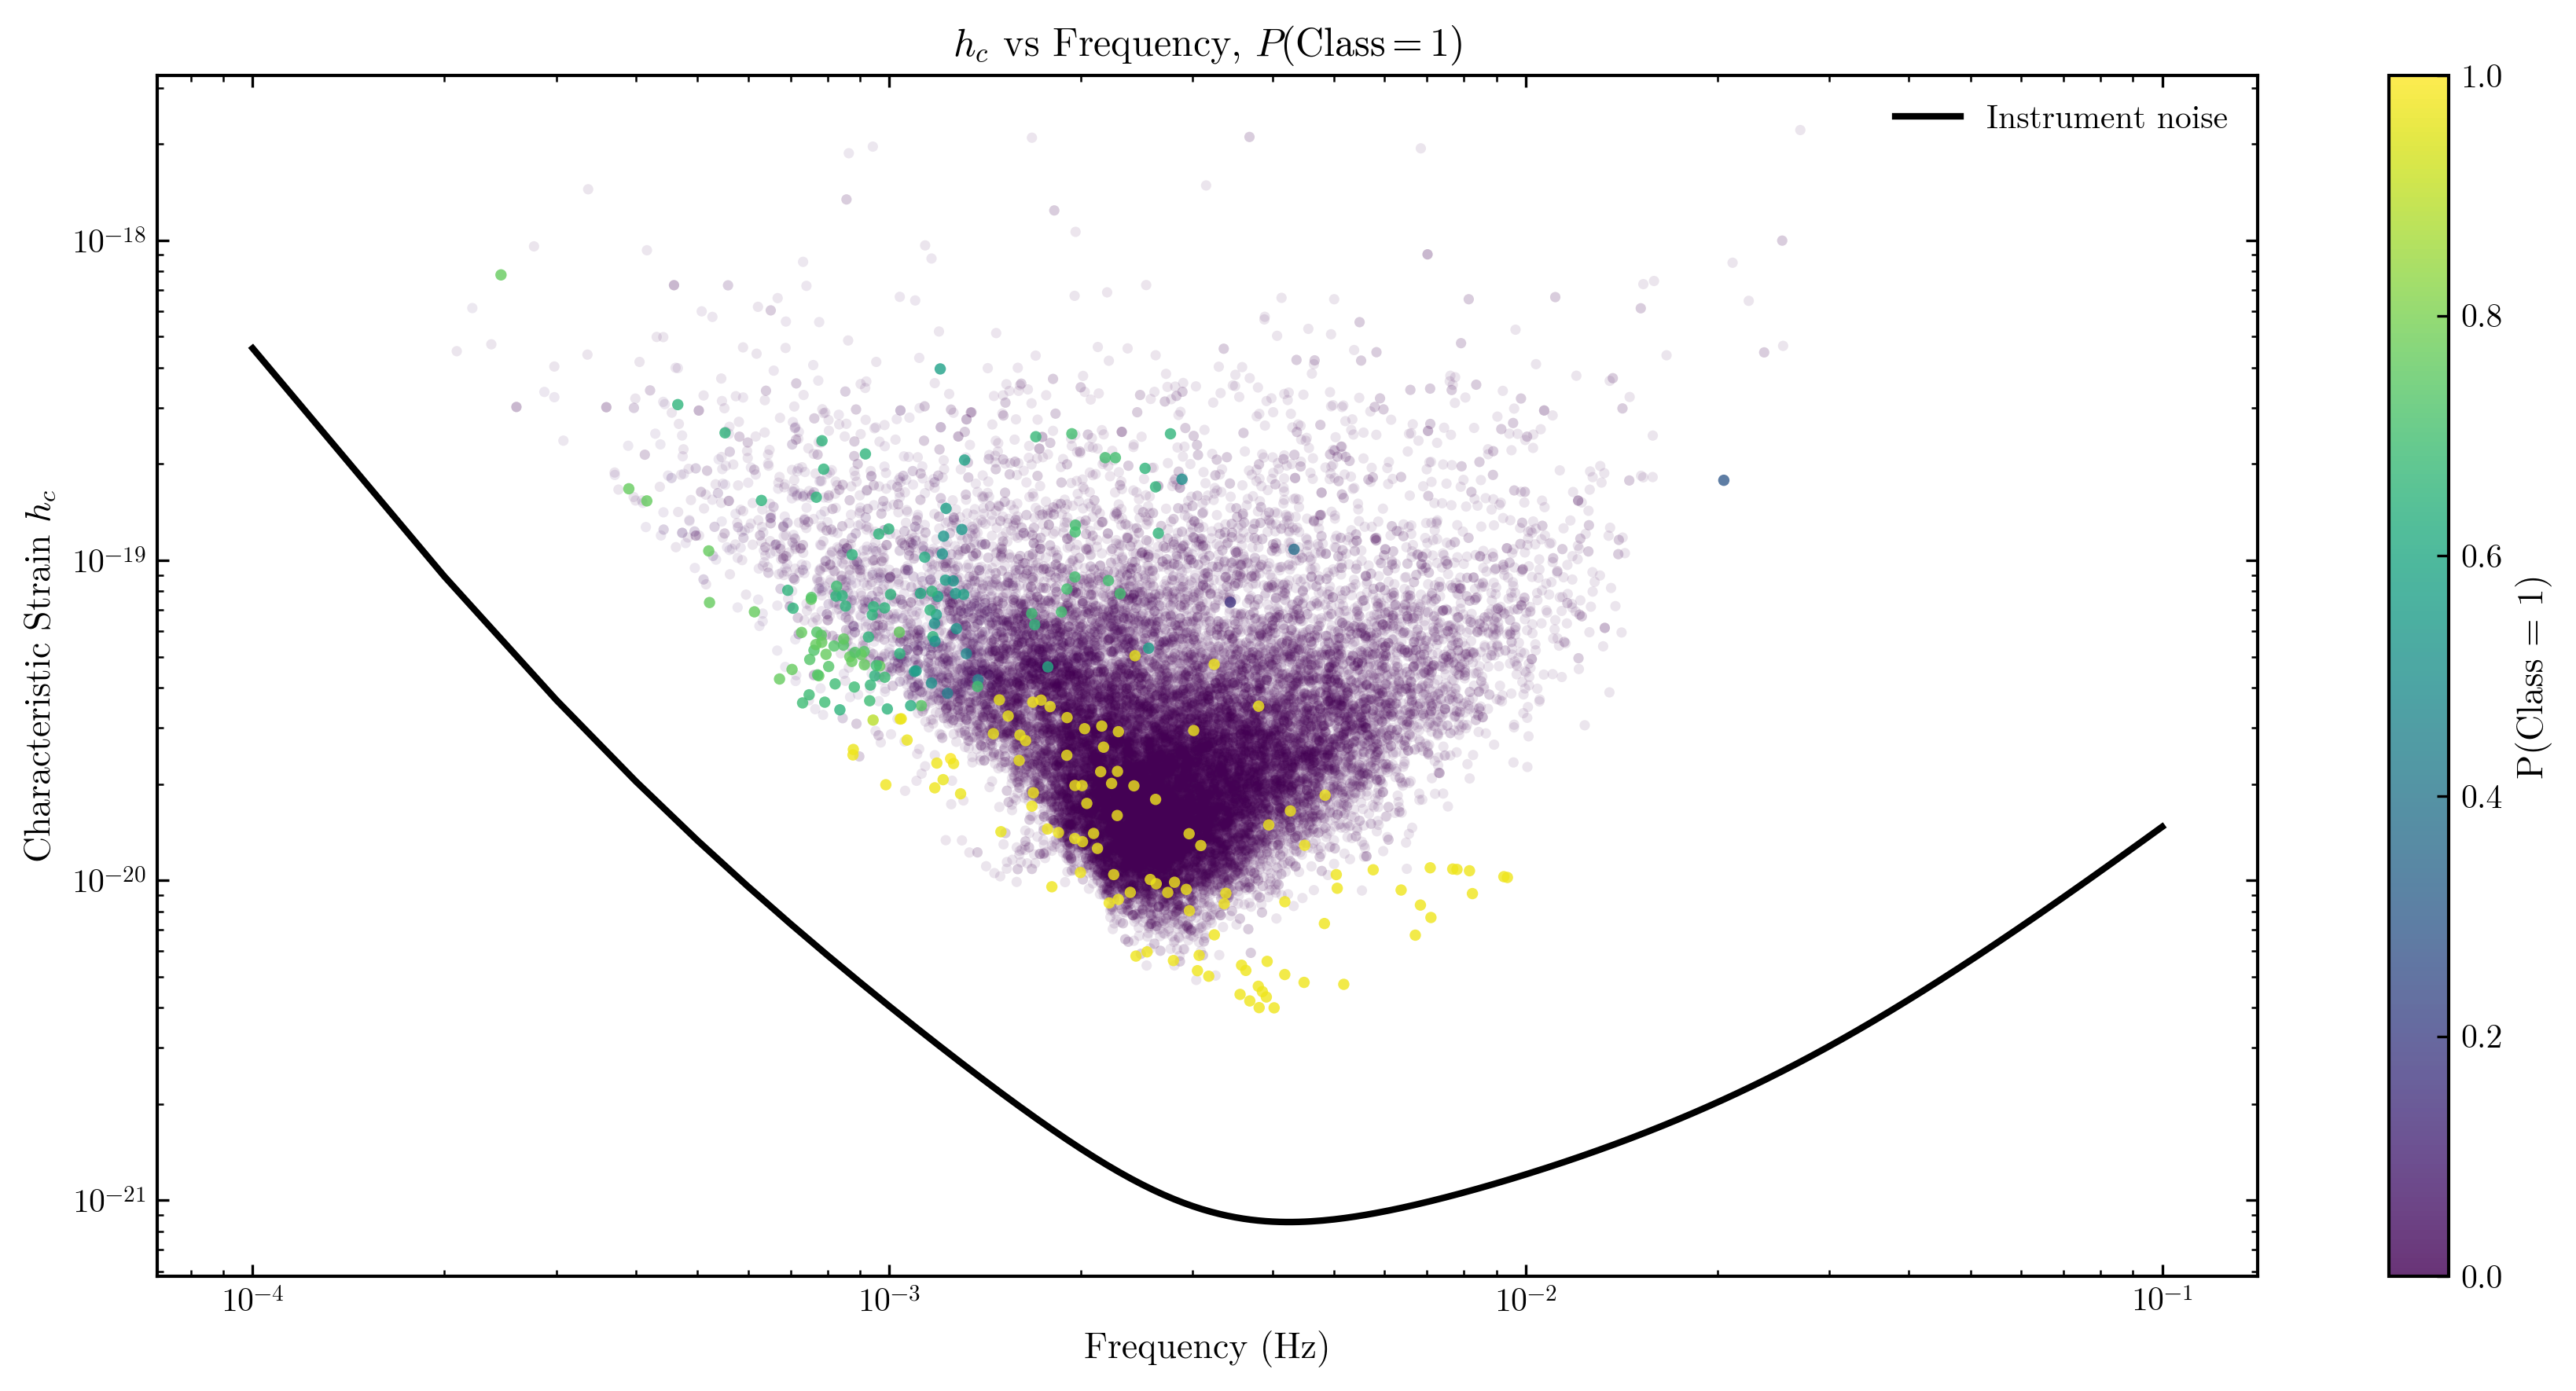

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm




dists = ngb_cat.pred_dist(X_test_scaled)
p1    = dists.probs[1, :]


threshold = 0.1
low_mask  = p1 <= threshold
high_mask = ~low_mask


plt.rc('font', family='Latin Modern Roman', size=10)
norm = Normalize(vmin=0, vmax=1)
cmap = cm.viridis


plt.figure(figsize=(12, 6))
plt.loglog(f_range, np.sqrt( f_range * lisasens/2), 'k-', linewidth=2, label='Instrument noise')
#   a) low‑prob
plt.scatter(
    f[low_mask], hc[low_mask],
    c=p1[low_mask], cmap=cmap, norm=norm,
    alpha=0.1, edgecolor='none', zorder=1, s=10
)

#   b) high‑prob
sc = plt.scatter(
    f[high_mask], hc[high_mask],
    c=p1[high_mask], cmap=cmap, norm=norm,
    alpha=0.8, edgecolor='none', zorder=2, s=12
)


plt.xscale('log')
plt.yscale('log')   


plt.xlabel('Frequency (Hz)')
plt.ylabel('Characteristic Strain $h_c$')
plt.title(r'$h_c$ vs Frequency, $P(\mathrm{Class}=1)$')
cbar = plt.colorbar(sc)
cbar.set_label('P(Class = 1)')
plt.legend()
plt.tight_layout()


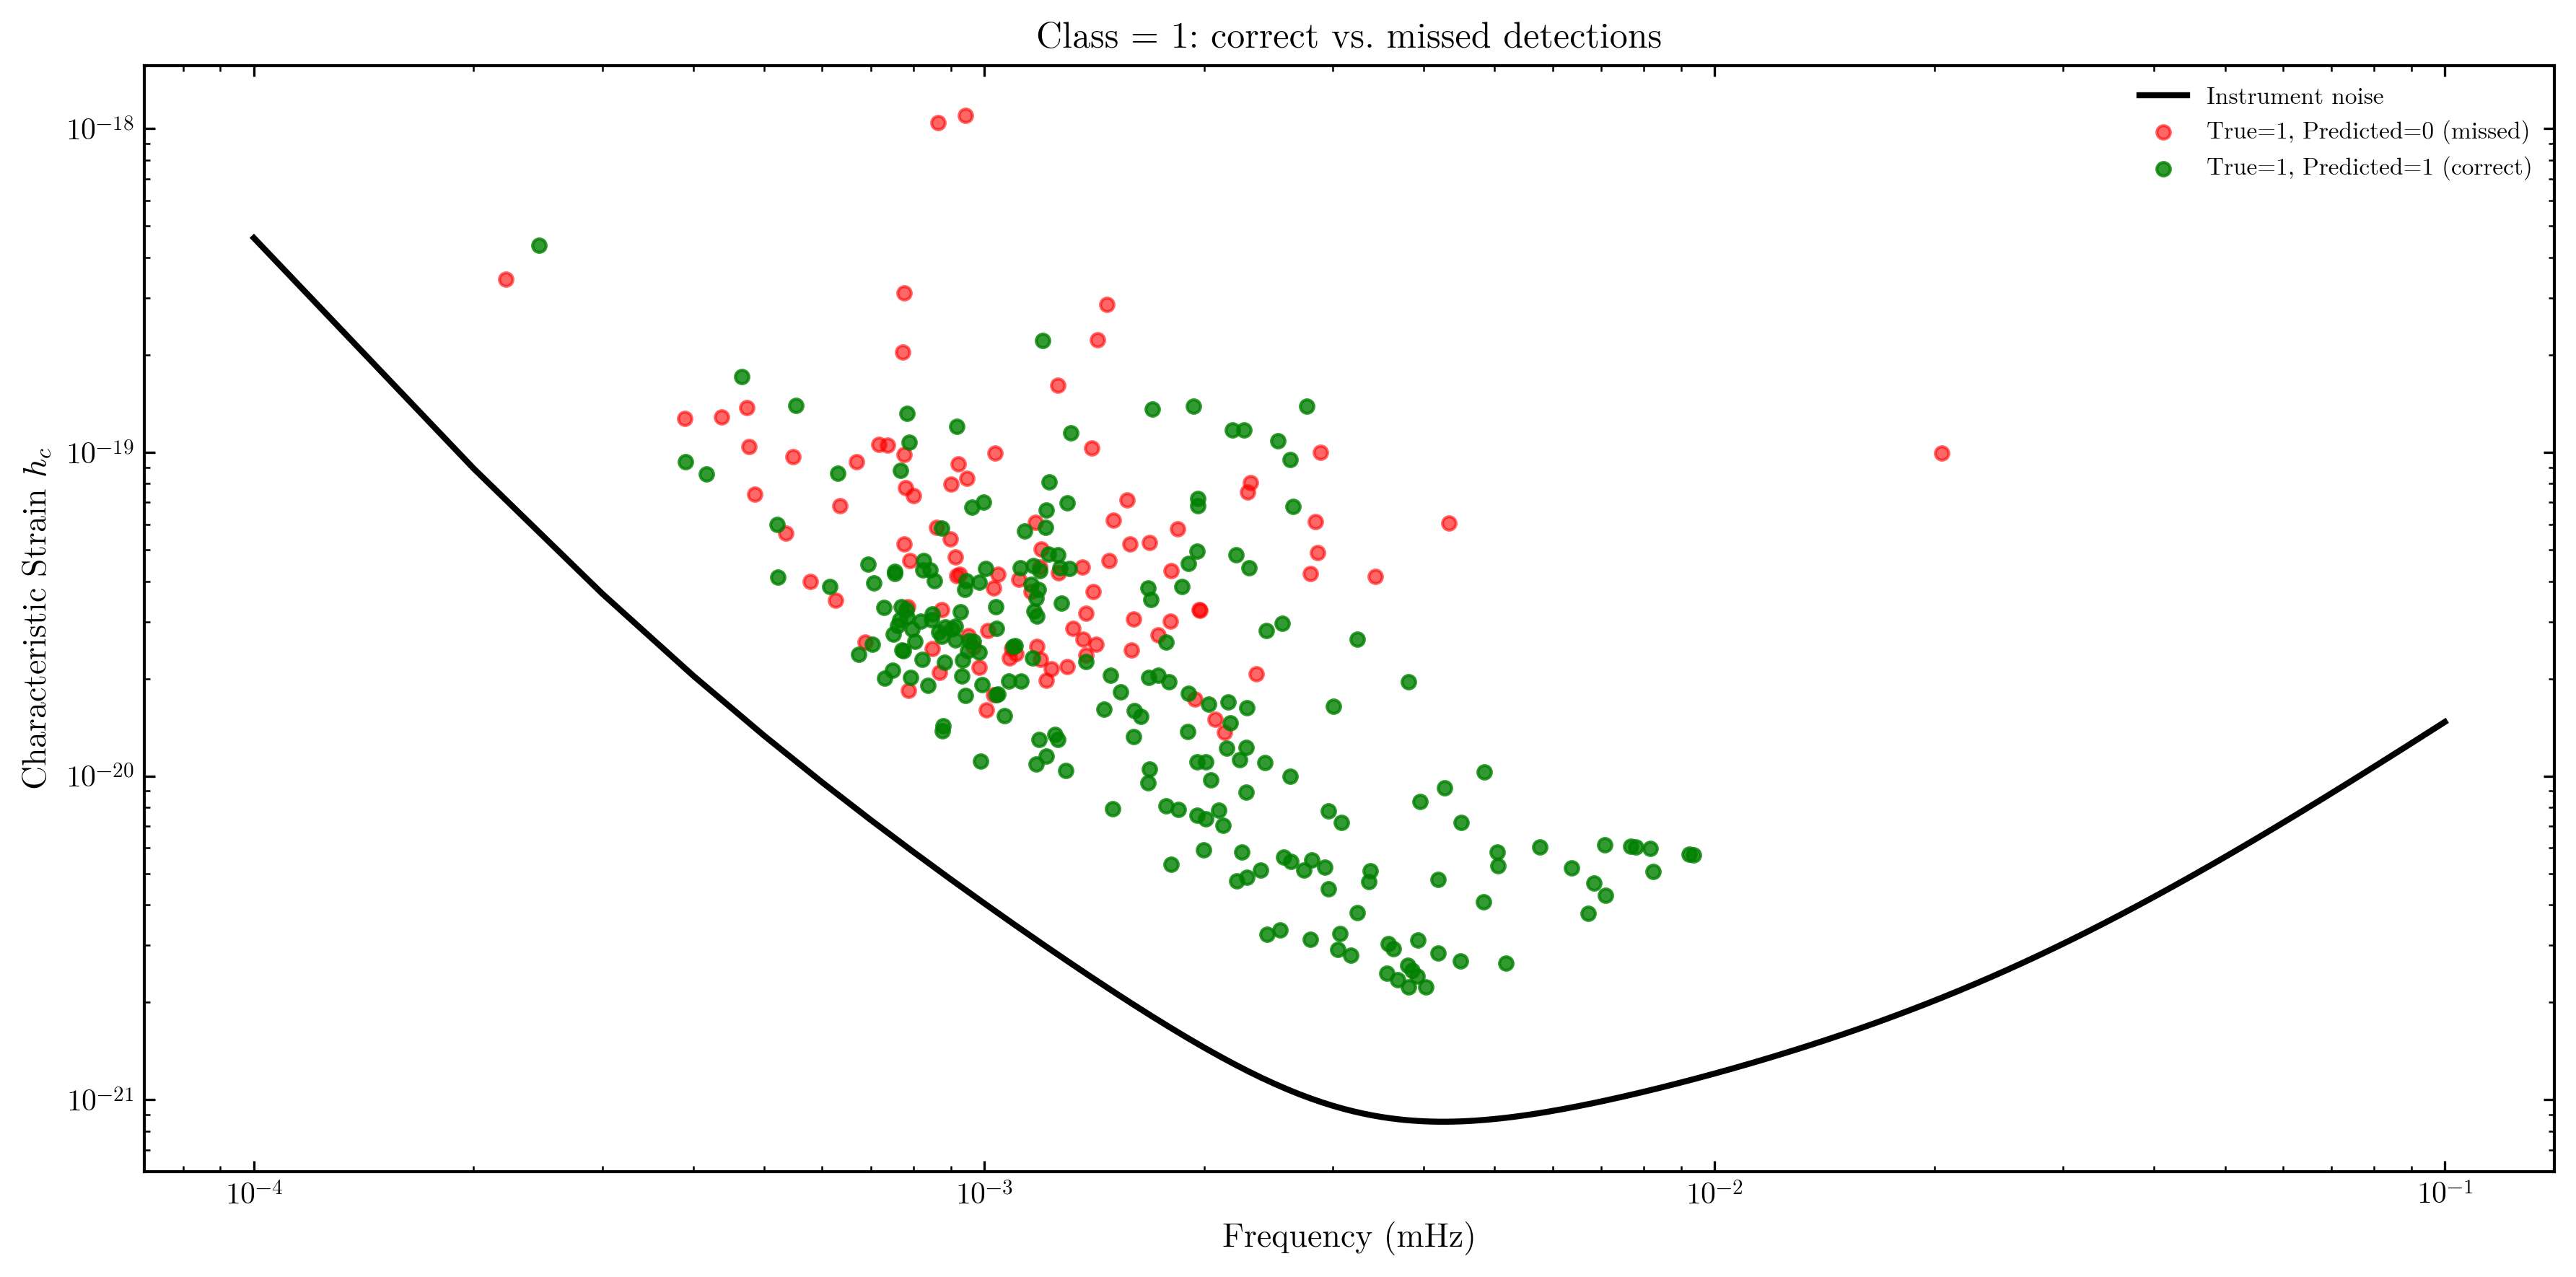

In [ ]:
y_pred   = ngb_cat.predict(X_test_scaled)
y_true   = y_val.values  
mask_pos = (y_true == 1)
mask_tp  = mask_pos & (y_pred == 1)   # true positives
mask_fn  = mask_pos & (y_pred == 0)   # false negatives

plt.figure(figsize=(12, 6))
plt.loglog(f_range, np.sqrt( f_range * lisasens/2), 'k-', linewidth=2, label='Instrument noise')

# a) Missed (false negatives) in red
plt.scatter(
    f[mask_fn], h_c[mask_fn],
    s=20, c='red', alpha=0.6,
    label='True=1, Predicted=0 (missed)',
    zorder=1
)

# b) Correct (true positives) in green
sc = plt.scatter(
    f[mask_tp], h_c[mask_tp],
    s=20, c='green', alpha=0.8,
    label='True=1, Predicted=1 (correct)',
    zorder=2
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (mHz)')
plt.ylabel(r'Characteristic Strain $h_c$')
plt.title('Class = 1: correct vs. missed detections')
plt.legend(loc='upper right', fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

In [19]:
p = dists.params['p1']
var  = p * (1-p)
std = np.sqrt(var)

/var/folders/rm/5j_dp79x6xx6xmxlxxs9k4y80000gn/T/ipykernel_3872/2550540127.py:14: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) Latin Modern Roman.
  plt.tight_layout()
/Users/irwin/opt/anaconda3/envs/sbi_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) Latin Modern Roman.
  fig.canvas.print_figure(bytes_io, **kw)


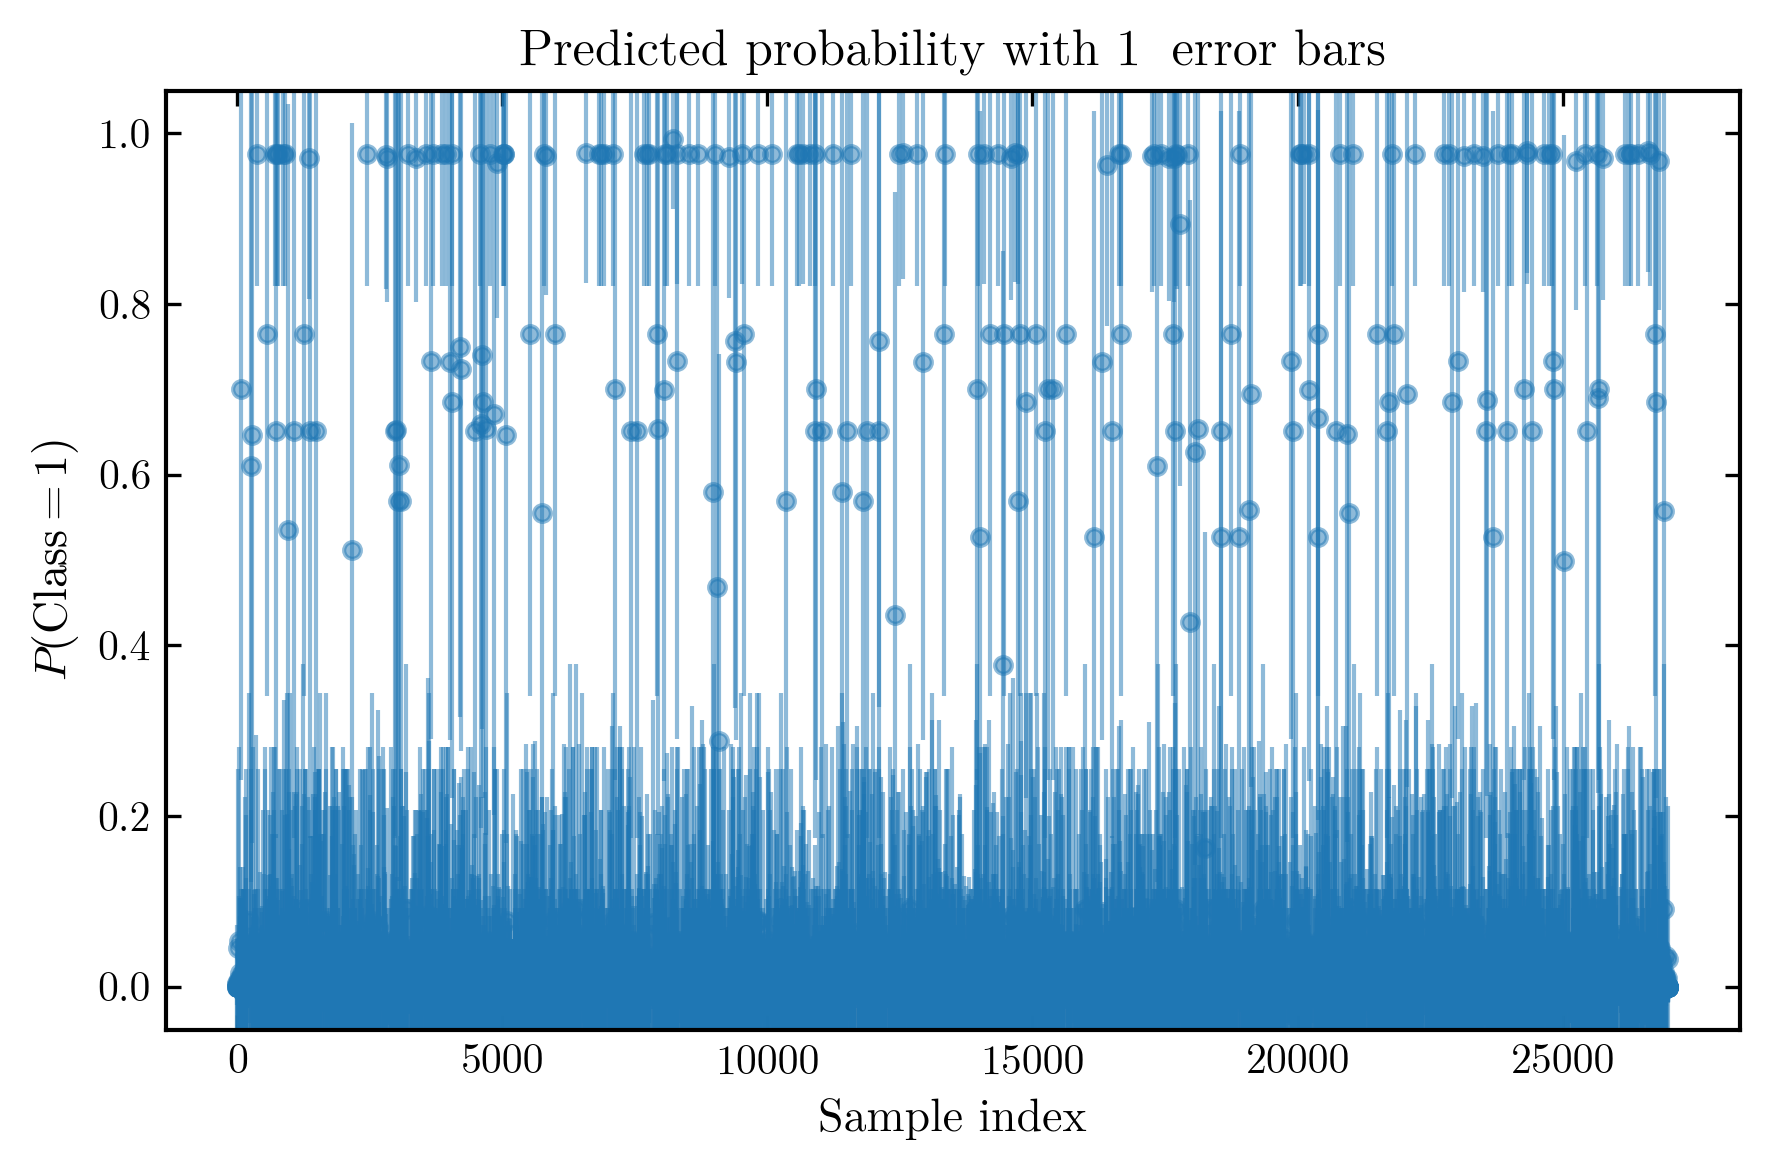

In [20]:
plt.figure(figsize=(6,4))
plt.errorbar(
    np.arange(len(p)), p,
    yerr=std,
    fmt='o',            # circle markers
    alpha=0.5,          # semi‑transparent
    markersize=4,
    elinewidth=1
)
plt.xlabel('Sample index')
plt.ylabel(r'$P(\mathrm{Class}=1)$')
plt.title('Predicted probability with 1σ error bars')
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

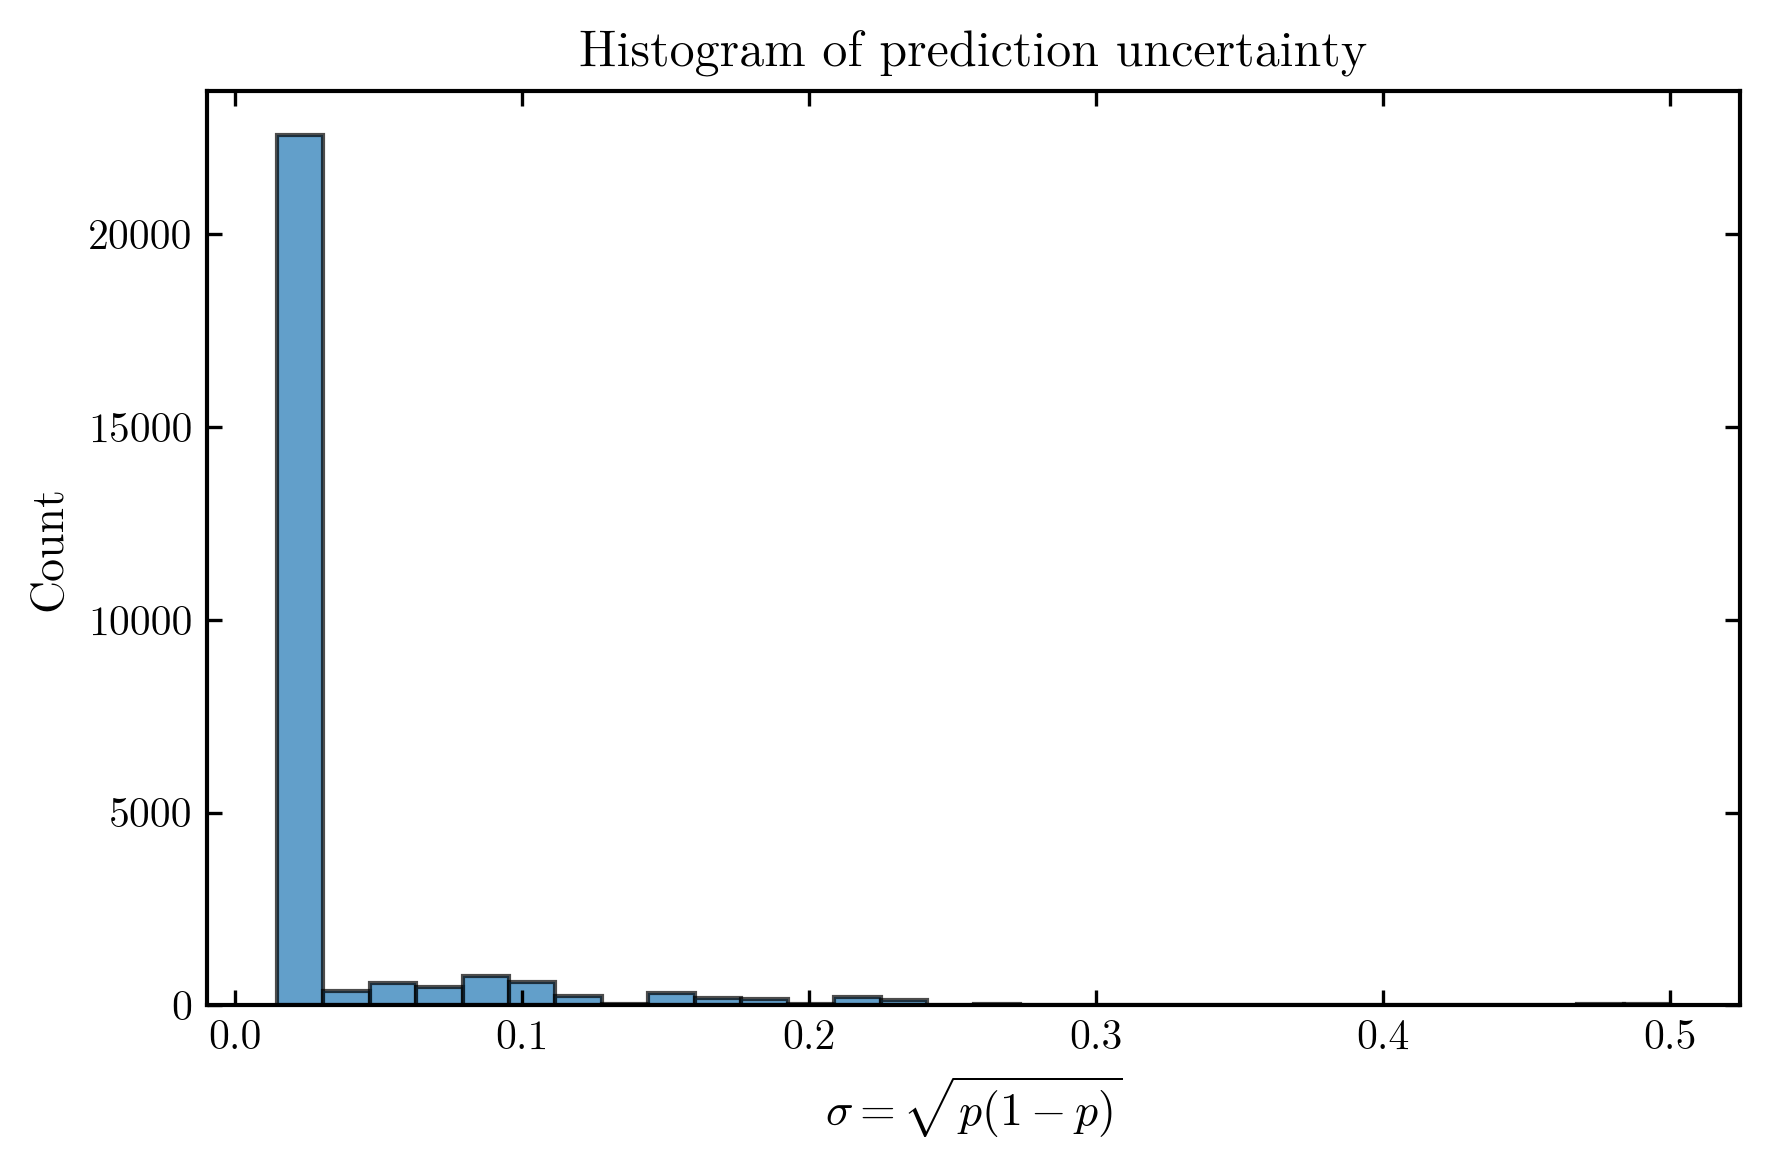

In [21]:
plt.figure(figsize=(6,4))
plt.hist(std, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel(r'$\sigma = \sqrt{p(1-p)}$')
plt.ylabel('Count')
plt.title('Histogram of prediction uncertainty')
plt.tight_layout()
plt.show()

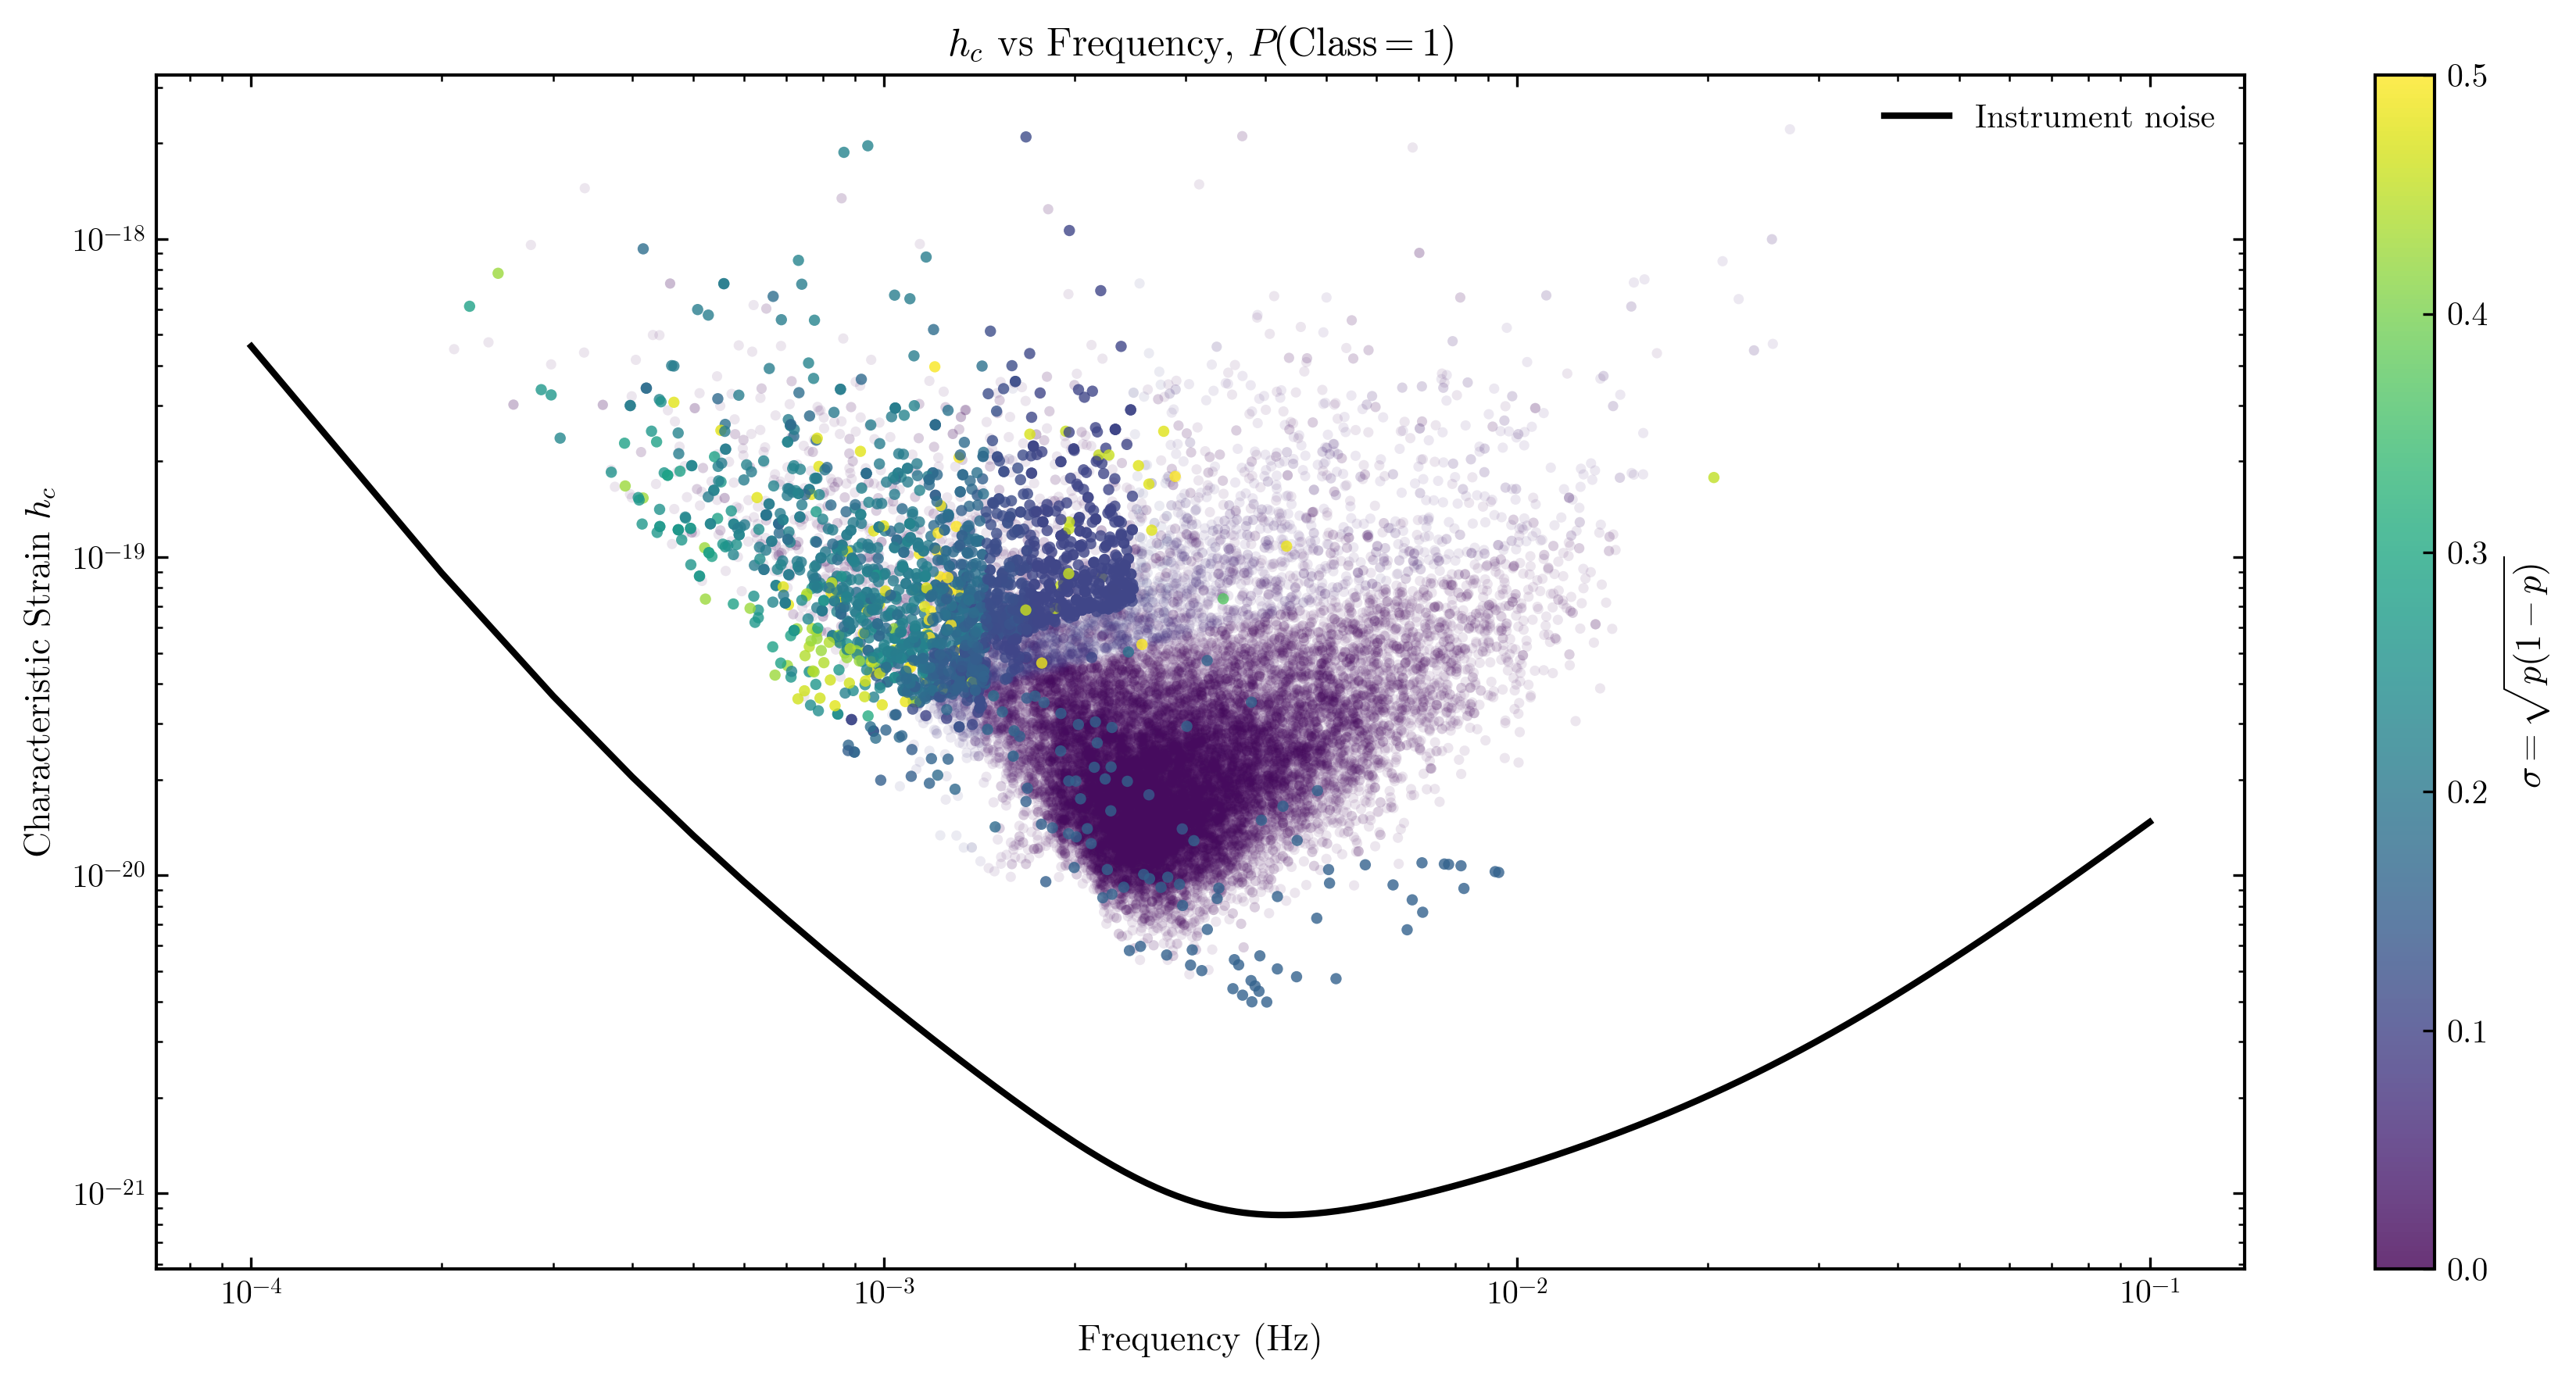

In [26]:
plt.rc('font', family='Latin Modern Roman', size=10)
norm = Normalize(vmin=0, vmax=0.5)
cmap = cm.viridis

threshold = 0.1
low_mask  = std <= threshold
high_mask = ~low_mask

plt.figure(figsize=(12, 6))
plt.loglog(f_range, np.sqrt( f_range * lisasens/2), 'k-', linewidth=2, label='Instrument noise')
#   a) low‑prob
plt.scatter(
    f[low_mask], hc[low_mask],
    c=std[low_mask], cmap=cmap, norm=norm,
    alpha=0.1, edgecolor='none', zorder=1, s=10
)

#   b) high‑prob
sc = plt.scatter(
    f[high_mask], hc[high_mask],
    c=std[high_mask], cmap=cmap, norm=norm,
    alpha=0.8, edgecolor='none', zorder=2, s=12
)


plt.xscale('log')
plt.yscale('log')   


plt.xlabel('Frequency (Hz)')
plt.ylabel('Characteristic Strain $h_c$')
plt.title(r'$h_c$ vs Frequency, $P(\mathrm{Class}=1)$')
cbar = plt.colorbar(sc)
cbar.set_label('P(Class = 1)')
cbar.set_label(r'$\sigma = \sqrt{p(1-p)}$')
plt.legend()
plt.tight_layout()

In [60]:
dists.sample(100)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])